# Forecasting the Ambient Solar Wind using Gradient Boosting Regressors

This code does the following:

1. **Load and visualise data**: Reads in values for the flux tube expansion factor (fp) and distance to the coronal hole boundary (d) taken along the subearth point. These are the results from coronal magnetic models (WSA from PFSS/SCS). Magnetic models maps for the full time range were provided by C. N. Arge. The final data, which has been produced as if it had been updated with a new map every day to mimic operational procedure, has a data resolution of 3.64 hours. This is 1/180th of a Carrington rotation, owing to the fact that each point was drawn from the maps with a 2 deg resolution.
2. **Define AmbSoWi object**: This object handles all model training and contains training and testing data.
3. **Set up XGB and do a grid search on different input parameters**: Define model (XGBoost implementation of Gradient Boosting Regressor), do grid search to test for optimal parameters. This is not run by default because it takes a very, very long time. Usually just the formerly-optimised parameters will be taken. These don't appear to change by much when taking different feature selections.
4. **Use feature importances to select optimal features**: Train the XGB model (model parameters determined in the last step) on ALL features to pick out which are the most important and select for less overtraining.
5. **Create plots of final results**: Produce presentation of results as example for publication. Also produce results for ISWAT working team for years 2008 and 2012.
6. **Example of model application**: A short code snippet showing how the model can be applied to new data.

Author: R. L. Bailey (IWF Graz / ZAMG Vienna).<br />Code created 2019-2020 at NASA Goddard Space Flight Center, Maryland, USA and the Space Research Institute (IWF), Graz, Austria.

In [1]:
import os
from collections import OrderedDict
import copy
import numpy as np
from datetime import datetime, timedelta
import math
import matplotlib.pyplot as plt
from matplotlib.dates import num2date, date2num, DateFormatter
import pickle # version 4.0
from types import SimpleNamespace

import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import scipy.signal
from scipy.stats import pearsonr

import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, make_scorer, classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
import xgboost as xgb

import predstorm as ps

sns.set(style="whitegrid")

In [2]:
def matlab2datetime(matlab_datenum):
    day = datetime.fromordinal(int(matlab_datenum))
    dayfrac = timedelta(days=matlab_datenum%1) - timedelta(days = 366)
    return day + dayfrac

def datetime2matlab(dt):
    mdn = dt + timedelta(days = 366)
    frac_seconds = (dt-datetime(dt.year,dt.month,dt.day,0,0,0)).seconds / (24.0 * 60.0 * 60.0)
    frac_microseconds = dt.microsecond / (24.0 * 60.0 * 60.0 * 1000000.0)
    return mdn.toordinal() + frac_seconds + frac_microseconds

## 1. Load and visualise data

In [3]:
def read_wsa_hux_output():
    """
    Output from the combined WSA/HUX model. 
    Only used for comparison with the trained model output to check it's really an improvement.
    
    WSA/HUX OUTPUT
    ---------------
    # Data format:
    # Col #1 : matlab date
    # Col #2 : WSA-calculated mean solar wind speed
    """
    wsa_data = np.loadtxt("data/wsahux_output.txt", delimiter=',')

    numdates = date2num(datetime.strptime("1992-05-20T06:55:29", "%Y-%m-%dT%H:%M:%S")) + wsa_data[:,0]
    wsa = wsa_data[:,1]
    first_date = numdates[0]
    last_date = numdates[-1]
    print("First date (WSA-HUX): {}".format(num2date(first_date)))
    print("Last date (WSA-HUX):  {}".format(num2date(last_date)))
    
    return (numdates, wsa)

In [4]:
def read_cmm_output(filepath="data/arge_subearth_data_all_1dayupdate.txt"):
    """
    This functions reads and returns all the main WSA data that the ML model will be trained on.
    
    CORONAL MAGNETIC MODEL (CMM or WSA) OUTPUT
    ------------------------------------------
    # Data format:
    # Col #1 : matlab date
    # Col #2 : bcor -------- coronal field [nT]
    # Col #3 : 1/fp -------- flux-tube expansion factor
    # Col #4 : lat/lon
    # Col #5 : lat/lon
    # Col #6 : bphot ------- photospheric field [G]
    # Col #7 : d ----------- distance to coronal hole boundary [rad]
    # Cols #8-X : cols 2-7 repeat for all 12 ADAPT models
    """
    cmm_data = np.loadtxt(filepath)
    mtimes = cmm_data[:,0]
    dates_all = np.array([matlab2datetime(t) for t in mtimes])
    numdates = date2num(dates_all)
    # Read every sixth column to get all ADAPT solutions
    bcor = cmm_data[:,1::6]
    fp = cmm_data[:,2::6]
    bphot = cmm_data[:,5::6]
    dchb = cmm_data[:,6::6]
    print("First date (CMM): {}".format(num2date(numdates[0])))
    print("Last date (CMM):  {}".format(num2date(numdates[-1])))
    
    return (numdates, dates_all, mtimes, fp, dchb, bcor, bphot)

In [5]:
def pack_into_dataframe(numdates, mtimes, fp, dchb, bcor, bphot, pers, pers_1up, pers_1down, vsw, wsa, f10_7=[], MgII=[], look_back=34):
    '''Takes raw data from read_cmm_output and packs in into a convenient pandas.DataFrame format
    that is indexed by date for extracting time ranges.
    Also produces all the past values for each variable (see look_back).'''
    def create_past_dataset(data, look_back=1):
        shifted = []
        # Fill up empty values with mean:
        for i in range(look_back-1):
            shifted.append(np.full((look_back), np.nanmean(data)))
        # Fill rest of array with past values:
        for i in range(len(data)-look_back+1):
            a = data[i:(i+look_back)]
            shifted.append(a)
        return np.array(shifted)

    # Create data sets with past values:
    fp_past = np.zeros((fp.shape[0], 12*look_back))
    dchb_past = np.zeros((dchb.shape[0], 12*look_back))
    bcor_past = np.zeros((bcor.shape[0], 12*look_back))
    bphot_past = np.zeros((bphot.shape[0], 12*look_back))
    for i in range(12):
        fp_past[:,i*look_back:(i+1)*look_back] = create_past_dataset(fp[:,i], look_back=look_back)
        dchb_past[:,i*look_back:(i+1)*look_back] = create_past_dataset(dchb[:,i], look_back=look_back)
        bcor_past[:,i*look_back:(i+1)*look_back] = create_past_dataset(bcor[:,i], look_back=look_back)
        bphot_past[:,i*look_back:(i+1)*look_back] = create_past_dataset(bphot[:,i], look_back=look_back)
            
    # Combine into one array:
    a_stack = [fp_past, dchb_past, bcor_past, bphot_past,
               vsw.reshape(-1,1), pers.reshape(-1,1),
               pers_1up.reshape(-1,1), pers_1down.reshape(-1,1)]
    if len(f10_7) > 0:
        a_stack.append(f10_7.reshape(-1,1))
    if len(MgII) > 0:
        a_stack.append(MgII.reshape(-1,1))
        MgII_past = np.zeros((fp.shape[0], 12*look_back))
        for i in range(12):
            MgII_past[:,i*look_back:(i+1)*look_back] = create_past_dataset(MgII, look_back=look_back)
        fp_MgII = fp_past * MgII_past
        dchb_MgII = dchb_past * MgII_past
        a_stack[0] = fp_MgII
        a_stack[1] = dchb_MgII
    fp_dchb_vsw = np.hstack(a_stack)
    
    # Remove rows with missing vsw values:
    vsw_nans = (~np.isnan(vsw)).nonzero()[0]
    fp_dchb_vsw = fp_dchb_vsw[vsw_nans]
    numdates = numdates[vsw_nans]
    mtimes = mtimes[vsw_nans]
    wsa = wsa[vsw_nans]

    # Define column labels:
    resolution = (numdates[10] - numdates[9])*24.
    print("Data resolution is {:.2f} hours.".format(resolution))
    all_labels = []
    for var in ['fp', 'dchb', 'bcor', 'bphot']:
        for i_a in range(12):
            all_labels.extend(['{}(t-{:3.0f}h)_A{}'.format(var, n*resolution, i_a) 
                               for n in np.arange(look_back-1,-1,-1)])
    all_labels.append('vsw')
    all_labels += ['pers', 'pers-1', 'pers+1']
    if len(f10_7) > 0:
        all_labels.append('f10.7')
    if len(MgII) > 0:
        all_labels.append('MgII')

    # Pack into DataFrame:
    df = pd.DataFrame(fp_dchb_vsw, columns=all_labels, dtype=np.float64)
    df['date'] = np.array([num2date(d).replace(tzinfo=None) for d in numdates])
    df = df.set_index(['date'])
    df['mtimes'] = mtimes
    df['wsa'] = wsa
    
    return df, all_labels

In [6]:
include_pers, include_f10_7, include_MgII = True, False, False
non_cmm_vars = 1
f10_7, MgII = [], []
numdates_wsa_hux, wsa_hux = read_wsa_hux_output()
numdates, dates_all, mtimes, fp, dchb, bcor, bphot = read_cmm_output()
wsa_hux = np.interp(numdates, numdates_wsa_hux, wsa_hux)
# Get solar wind data (OMNI variables interpolated to same time stamps):
# Download from https://spdf.gsfc.nasa.gov/pub/data/omni/low_res_omni/omni2_all_years.dat
omni = ps.get_omni_data(filepath="data/omni2_all_years.dat")
# There aren't too many nans in the time range, and it works better with them interpolated than with them removed:
omni.interp_nans()
vsw = np.interp(numdates, omni['time'], omni['speed'])
# OPTIONAL: Get MgII index:
if include_MgII:
    # Download from https://www.iup.uni-bremen.de/gome/solar/MgII_composite.dat
    MgII_data = np.genfromtxt(open('data/MgII_composite.dat', 'rb'), skip_header=22)
    MgII_time = np.array([date2num(datetime(int(x[0]),int(x[1]),1) + timedelta(days=x[2])) for x in MgII_data])
    MgII_index = MgII_data[:,3]
    MgII = np.interp(numdates, MgII_time, MgII_index)
    non_cmm_vars += 1
# OPTIONAL: Include F10.7 index:
if include_f10_7:
    f10_7 = np.interp(numdates, omni['time'], omni['f10.7'])
    non_cmm_vars += 1
# Roll by 180 points (1 Carrington rotation) for persistence:
if include_pers:
    pers = np.roll(vsw, 180)
    pers_1up = np.roll(vsw, 173)    # CR -1 day
    pers_1down = np.roll(vsw, 187)  # CR +1 day
    non_cmm_vars += 3
print(vsw.shape, wsa_hux.shape, pers.shape, fp.shape)
look_back = 42 # data points, 6.4 days
df, all_labels = pack_into_dataframe(numdates, mtimes, fp, dchb, bcor, bphot, pers, pers_1up, pers_1down, 
                                     vsw, wsa_hux, f10_7=f10_7, MgII=MgII, look_back=look_back)

First date (WSA-HUX): 1992-05-20 06:55:29+00:00
Last date (WSA-HUX):  2017-10-10 04:31:29+00:00
First date (CMM): 1992-05-24 07:04:19.056000+00:00
Last date (CMM):  2017-10-20 06:36:57.628800+00:00
(61255,) (61255,) (61255,) (61255, 12)
Data resolution is 3.64 hours.


In [7]:
# Create DataFrame with ICMEs removed:
# Download from https://doi.org/10.6084/m9.figshare.4588315.v1
icmes_omni = ps.get_icme_catalogue("data/HELCATS_ICMECAT_v10_SCEQ.txt", 'Wind')
df_no_icmes = copy.deepcopy(df)
for icme in icmes_omni:
    df_no_icmes.loc[num2date(icme['ICME_START_TIME']).replace(tzinfo=None):
                    num2date(icme['ICME_END_TIME']).replace(tzinfo=None)] = np.nan

## 2. Define AmbientSolarWind (AmbSoWi) Model Object

In [8]:
class AMBSOWI_model():
    
    def __init__(self, labels, model, modelname='XGB', label_target='vsw', verbose=True):
        self.labels = labels
        self.label_target = label_target
        self.model = model
        # Train and test data:
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.dmatrix = None
        self.min_date = None
        self.max_date = None
        # Model metadata:
        self.modelname = modelname
        self.train_test_split = None
        self.random_state = None
        self.shuffle = None
        self.classifier = False
        if modelname.lower() == 'xgb':
            self.xgboost = True
        else:
            self.xgboost = False
        self.verbose = verbose
        # Results:
        self.vsw_mod_train = None
        self.vsw_mod_test = None
        # Actual solar wind data:
        self.vsw_train = None
        self.vsw_test = None
        # WSA-HUX model output:
        self.wsa_train = None
        self.wsa_test = None
        
        
    def extract_train_test_data(self, df, min_date, max_date, train_test=0.8, random_state=42, 
                                shuffle=True):
        """Extracts train and test data from dataframe object."""

        # Find your features
        features = np.array(df.loc[min_date:max_date][self.labels])
        # Multiplying by 1.2 and subtracting 100 helps the model adjust to larger SW swings,
        # otherwise it is good at staying around the mean but doesn't reach the peaks/troughs
        # as well. Errors in the test data are unchanged by this edit, but the statistical
        # distribution of predicted SW values matches the original data better.
        target = np.array(df.loc[min_date:max_date][self.label_target]) * 1.2 - 100.

        # Do the splits
        # Note that the test set here is for running validation.
        # The true test set comes later in print_rmse_values with _ftest.
        X_train, X_test, y_train, y_test = train_test_split(features, target.reshape(-1,1), 
                                                            shuffle=shuffle, train_size=train_test, 
                                                            test_size=1.-train_test,
                                                            random_state=random_state)
        self.X_train, self.X_test = X_train, X_test
        self.y_train, self.y_test = y_train, y_test
        self.n_features = self.X_train.shape[1]
        if self.verbose:
            print("Number of features:\t{}".format(self.n_features))
            print("Train / test split:\t{} / {}".format(self.X_train.shape[0], self.X_test.shape[0]))
        
        # Define targets for comparison:
        self.vsw_train, self.vsw_test = self.y_train, self.y_test
        # Define WSA model output for comparison
        wsa_data = np.array(df.loc[min_date:max_date]['wsa'])
        self.wsa_train, self.wsa_test, _, _ = train_test_split(wsa_data, wsa_data, shuffle=shuffle,
                                                               train_size=train_test, 
                                                               test_size=1.-train_test,
                                                               random_state=random_state)
        
        # Set model parameters:
        self.min_date, self.max_date = min_date, max_date
        self.random_state = random_state
        self.train_test_split = train_test
        self.shuffle = shuffle
            
            
    def train_xgb_model(self, **params):
        """Train model on X_train."""

        # Train model:
        eval_set = [(self.X_train, self.y_train), (self.X_test, self.y_test)]
        self.model.fit(self.X_train, self.y_train.ravel(), eval_set=eval_set, verbose=self.verbose,
                       **params)

        # Make prediction:
        trainPredict = self.model.predict(self.X_train)
        testPredict = self.model.predict(self.X_test)
        self.vsw_mod_train = trainPredict.reshape(-1,1)
        self.vsw_mod_test = testPredict.reshape(-1,1)
            
        if self.verbose:
            print("Train score: {:.2f}".format(self.model.score(self.X_train, self.y_train)))
            print("Val. score:  {:.2f}".format(self.model.score(self.X_test, self.y_test)))

        
    def print_rmse_values(self, df=[], min_date_test=None, max_date_test=None):
        """Prints RMSE values between fitted model and WSA/HUX results.
        
        NOTE: if you get the error:
        TypeError: No loop matching the specified signature and casting was found for ufunc add
        ... make sure the np arrays are squeezed."""
        
        if len(df) == 0:
            use_test = False
        else:
            use_test = True

        if use_test:
            X_ftest = np.array(df.loc[min_date_test:max_date_test][self.labels])
            vsw_ftest = np.array(df.loc[min_date_test:max_date_test]['vsw']).reshape(-1,1)
            wsa_ftest = np.array(df.loc[min_date_test:max_date_test]['wsa']).reshape(-1,1)
            ftestPredict = self.model.predict(X_ftest)
            vsw_mod_ftest = ftestPredict.reshape(-1,1)
        
        rmse_train = np.sqrt(mean_squared_error(self.vsw_mod_train, self.vsw_train))
        rmse_test = np.sqrt(mean_squared_error(self.vsw_mod_test, self.vsw_test))
        #pcc_train = pearsonr(self.vsw_mod_train, self.vsw_train)[0][0]
        #pcc_test = pearsonr(self.vsw_mod_test, self.vsw_test)[0][0]
        pcc_train = pearsonr(np.squeeze(self.vsw_mod_train), np.squeeze(self.vsw_train))[0]
        pcc_test = pearsonr(np.squeeze(self.vsw_mod_test), np.squeeze(self.vsw_test))[0]
        print("{}(train)  RMSE = {:.1f} km/s\tPCC = {:.2f}\tSTD = {:.2f}".format(
            self.modelname, rmse_train, pcc_train, np.std(self.vsw_mod_train)))
        print("{}(val.)   RMSE = {:.1f} km/s\tPCC = {:.2f}\tSTD = {:.2f}".format(
            self.modelname, rmse_test, pcc_test, np.std(self.vsw_mod_test)))
        if use_test:
            rmse_ftest = np.sqrt(mean_squared_error(vsw_mod_ftest, vsw_ftest))
            pcc_ftest = pearsonr(np.squeeze(vsw_mod_ftest), np.squeeze(vsw_ftest))[0]
            print("{}(TEST)   RMSE = {:.1f} km/s\tPCC = {:.2f}\tSTD = {:.2f}".format(
                self.modelname, rmse_ftest, pcc_ftest, np.std(vsw_mod_ftest)))
        print("-------------------------------------------")
        rmse_wsa_train = np.sqrt(mean_squared_error(self.wsa_train, self.vsw_train))
        rmse_wsa_test = np.sqrt(mean_squared_error(self.wsa_test, self.vsw_test))
        pcc_wsa_train = pearsonr(self.wsa_train, np.squeeze(self.vsw_train))[0]
        pcc_wsa_test = pearsonr(self.wsa_test, np.squeeze(self.vsw_test))[0]
        print("WSA(train) RMSE = {:.1f} km/s\tPCC = {:.2f}\tSTD = {:.2f}".format(
            rmse_wsa_train, pcc_wsa_train, np.std(self.wsa_train)))
        print("WSA(val.)  RMSE = {:.1f} km/s\tPCC = {:.2f}\tSTD = {:.2f}".format(
            rmse_wsa_test, pcc_wsa_test, np.std(self.wsa_test)))
        if use_test:
            rmse_wsa_ftest = np.sqrt(mean_squared_error(wsa_ftest, np.squeeze(vsw_ftest)))
            pcc_wsa_ftest = pearsonr(np.squeeze(wsa_ftest), np.squeeze(vsw_ftest))[0]
            print("WSA(TEST)  RMSE = {:.1f} km/s\tPCC = {:.2f}\tSTD = {:.2f}".format(
                rmse_wsa_ftest, pcc_wsa_ftest, np.std(wsa_ftest)))

    
    def plot_train_vs_test(self, df):
        """Plot of training vs test results."""

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18,10))
        start, end = datetime(2008,1,1), datetime(2008,6,1)
        X_sample = np.array(df.loc[start:end][self.labels])
        input_sample = X_sample
        dates = df.loc[start:end].index
        dates = [pd.to_datetime(str(x)) for x in dates]
        vsw_model = self.model.predict(input_sample).reshape(-1,1)
        vsw_sample = np.array(df.loc[start:end][self.label_target]).reshape(-1,1)
        wsa_sample = np.array(df.loc[start:end]['wsa']).reshape(-1,1)
        ax1.plot_date(dates, vsw_model, 'b-', label='ML')
        ax1.plot_date(dates, vsw_sample, 'r-', label=self.label_target)
        ax1.plot_date(dates, wsa_sample, 'k--', alpha=0.5, label="WSA")
        ax1.set_xlim((start, end))

        start, end = datetime(2014,1,1), datetime(2014,6,1)
        X_sample = np.array(df.loc[start:end][self.labels])
        input_sample = X_sample
        dates = df.loc[start:end].index
        dates = [pd.to_datetime(str(x)) for x in dates]
        vsw_model = self.model.predict(input_sample).reshape(-1,1)
        vsw_sample = np.array(df.loc[start:end][self.label_target]).reshape(-1,1)
        wsa_sample = np.array(df.loc[start:end]['wsa']).reshape(-1,1)
        ax2.plot_date(dates, vsw_model, 'b-', label='ML')
        ax2.plot_date(dates, vsw_sample, 'r-', label=self.label_target)
        ax2.plot_date(dates, wsa_sample, 'k--', alpha=0.5, label="WSA")
        ax2.set_xlim((start, end))

        ax1.set_title("QUIET")
        ax2.set_title("ACTIVE")
        plt.legend()
        ax1.set_ylim((220, 800))
        ax2.set_ylim((220, 800))
        plt.show()
        
    
    def plot_feature_importances(self, return_feat_imp=False):
        """Plot importance of features to model."""
        
        # Find feature importances for full dataset:
        fig = plt.figure(figsize=(20,4))
        feat_imp = pd.Series(self.model.feature_importances_, self.labels).sort_values(ascending=False)
        optim_cols = list((feat_imp[:10].axes)[0])
        if self.verbose:
            print("Optimal input features (top 10):", optim_cols)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        plt.show()
        
        if return_feat_imp:
            return optim_cols, feat_imp
        else:
            return optim_cols
        
        
    def write_model_results(self, filepath, features, mtimes):
        # Write results:
        datelist = mtimes.reshape(-1,1)
        full_pred = self.model.predict(full_features)
        full_pred = full_pred.reshape(-1,1)
        ml_data = np.hstack((datelist, full_pred))
        file_fmt = '%12.4f%8.2f'
        header = '{:12s}{:8s}'.format('mtime', 'vsw_ml')
        if not os.path.exists('results'):
            os.mkdir('results')
        np.savetxt(filepath, ml_data, header=header, delimiter='',fmt=file_fmt)

In [9]:
# PARAMETERS FOR MODELS:

# Only keep time-shifted variables greater than 2 days
# (Using all_labels[:-non_cmm_vars] makes sure vsw and pers are not included, only ADAPT solutions)
all_adapt_labels = [l for l in all_labels[:-non_cmm_vars] if float(
            l.split('_')[0].strip('fp').strip('dchb').strip('bcor').strip('bphot')[3:6]) >= 45.]
try:
    all_adapt_labels.remove('vsw')   # Make extra sure target doesn't leak into training
except:
    pass

# Extract according to ADAPT models and reduce to daily timesteps to make reduced_cols:
adapt_ver = 'all' #'A0'
hour_vals = ['145', '120', ' 95', ' 62', ' 47']
if adapt_ver == 'all':
    labels = all_adapt_labels
    reduced_cols = []
    for i_a in range(12):
        reduced_cols += (['fp(t-{}h)_A{}'.format(h, i_a) for h in hour_vals] 
                        + ['dchb(t-{}h)_A{}'.format(h, i_a) for h in hour_vals]
                        + ['bcor(t-{}h)_A{}'.format(h, i_a) for h in hour_vals] 
                        + ['bphot(t-{}h)_A{}'.format(h, i_a) for h in hour_vals]
                       )
else:
    labels = [l for l in all_adapt_labels[:-3] if l.split('_')[1] == adapt_ver]
    reduced_cols = (['fp(t-{}h)_{}'.format(h, adapt_ver) for h in hour_vals] 
                    + ['dchb(t-{}h)_{}'.format(h, adapt_ver) for h in hour_vals]
                    + ['bcor(t-{}h)_{}'.format(h, adapt_ver) for h in hour_vals] 
                    + ['bphot(t-{}h)_{}'.format(h, adapt_ver) for h in hour_vals]
                   )

test_on_sc24 = True   # Testing is carried out on Solar Cycle 24 if True
if test_on_sc24:
    min_date = datetime(1992,5,24) + timedelta(days=27.27)
    max_date = datetime(2006,10,10)
    min_date_test = datetime(2006,10,10)
    max_date_test = datetime(2017,10,10)
else:
    min_date_test = datetime(1992,5,24) + timedelta(days=27.27)
    max_date_test = datetime(2003,5,24)
    min_date = datetime(2003,5,24)
    max_date = datetime(2017,10,10)

## 3. Set up XGB

Notes:
- Setting max_leaf_nodes as lower means you need to set n_iter_no_change as lower to ensure no overtraining. Results with lower leaf nodes seem to include more jumps than others.

In [10]:
# Parameters are close to optimal values from a test hyperparameter grid search
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                          max_depth=2, alpha=10, n_estimators=600)

## 4. Use Feature Importances to select optimal features

Train on ALL features (excluding persistence) of model and then do a feature selection determined by which are most important.

Number of features: 1392

RESULTS FOR ALL INPUT VALUES
----------------------------
XGB(train)  RMSE = 94.3 km/s	PCC = 0.69	STD = 80.32
XGB(val.)   RMSE = 98.6 km/s	PCC = 0.64	STD = 79.18
XGB(TEST)   RMSE = 88.7 km/s	PCC = 0.52	STD = 65.52
-------------------------------------------
WSA(train) RMSE = 145.1 km/s	PCC = 0.49	STD = 74.39
WSA(val.)  RMSE = 144.9 km/s	PCC = 0.48	STD = 73.99
WSA(TEST)  RMSE = 120.8 km/s	PCC = 0.44	STD = 66.72


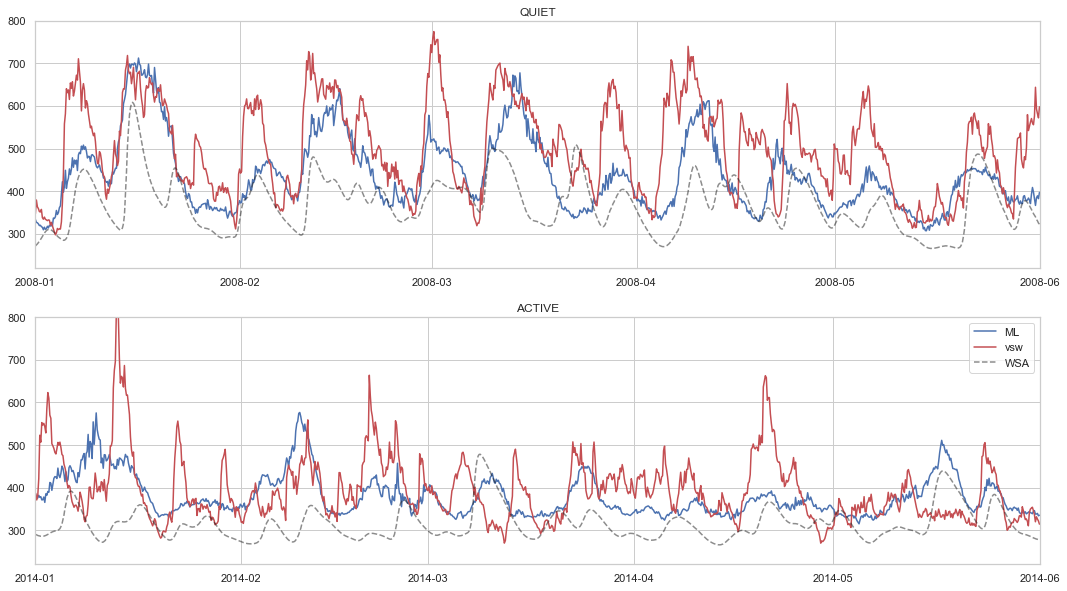

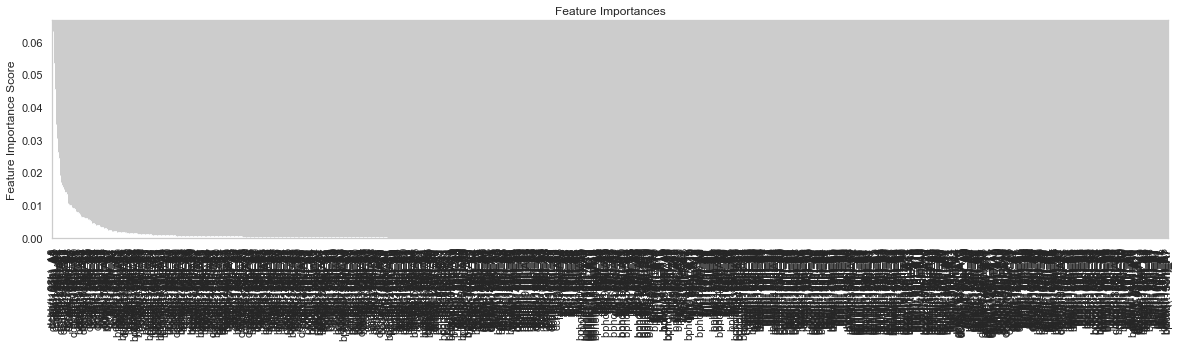

In [11]:
print("Number of features:", len(labels))
A_all = AMBSOWI_model(labels, xg_reg, verbose=False)
A_all.extract_train_test_data(df, min_date, max_date)
A_all.train_xgb_model(early_stopping_rounds=5)
print("")
print("RESULTS FOR ALL INPUT VALUES")
print("----------------------------")
A_all.print_rmse_values(df, min_date_test, max_date_test)
A_all.plot_train_vs_test(df)
optim_cols, all_feat_imp = A_all.plot_feature_importances(return_feat_imp=True)

#### Plot features according to type and importance

In [12]:
fi_adapt, fi_var, fi_timeshift = {}, {}, {}
percent = 100.  # change to 1 if you want fractions
for i, feature in enumerate(all_feat_imp.axes[0]):
    fi_value = all_feat_imp[i] * percent
    feat_split = feature.split('_')
    str_adapt = int(feat_split[1][1:])
    feat_split2 = feat_split[0].split('(')
    str_var, str_timeshift = feat_split2[0], round(float(feat_split2[1][2:5])/24.)
    
    # Variable dependence:
    if str_var in fi_var.keys():
        fi_var[str_var] += fi_value
    else:
        fi_var[str_var] = fi_value
    # ADAPT model dependence:
    if str_adapt in fi_adapt.keys():
        fi_adapt[str_adapt] += fi_value
    else:
        fi_adapt[str_adapt] = fi_value
    # Timeshift dependence:
    if str_timeshift in fi_timeshift.keys():
        fi_timeshift[str_timeshift] += fi_value
    else:
        fi_timeshift[str_timeshift] = fi_value

{'dchb': 41.11301720040501, 'fp': 35.10007741372192, 'bcor': 18.61930675804615, 'bphot': 5.167604690586813}

{8: 19.44055961939739, 4: 9.009657401475124, 2: 16.083523216593676, 7: 17.120951200195123, 11: 6.8519939901307225, 1: 9.300684841582552, 10: 5.962915997224627, 5: 8.108117841766216, 9: 4.022951444630962, 0: 2.1133049559239225, 3: 1.488995910040103, 6: 0.4963496437994763}
{4: 48.8674226362491, 5: 24.558119564767367, 3: 12.08932823806208, 2: 5.679760366092523, 6: 8.805375257588821}


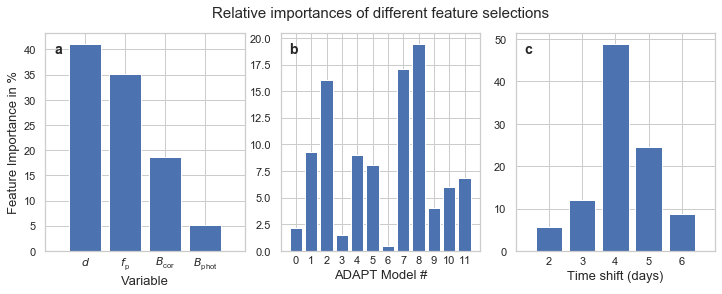

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4))
fs_label = 13

print(fi_var)
print("")
centers = range(len(fi_var))
var_labels = {'dchb': '$d$', 'fp': '$f\mathregular{_p}$', 'bcor': '$B\mathregular{_{cor}}$', 
              'bphot': '$B\mathregular{_{phot}}$'} 
ax1.bar(centers, fi_var.values(), align='center', tick_label=[var_labels[x] for x in list(fi_var.keys())])
ax1.set_xlim([-1, len(fi_var)])
ax1.set_xlabel("Variable", fontsize=fs_label)
ax1.tick_params(axis='x', pad=-2)
ax1.set_ylabel("Feature Importance in %", fontsize=fs_label)

print(fi_adapt)
fi_adapt_sorted = OrderedDict(sorted(fi_adapt.items()))
centers = range(len(fi_adapt_sorted))
ax2.bar(centers, fi_adapt_sorted.values(), align='center', tick_label=list(fi_adapt_sorted.keys()))
ax2.set_xlim([-1, len(fi_adapt_sorted)])
ax2.set_xlabel("ADAPT Model #", fontsize=fs_label)
ax2.tick_params(axis='x', pad=-2)
#ax2.set_ylabel("Feature Importance in %")

print(fi_timeshift)
fi_timeshift_sorted = OrderedDict(sorted(fi_timeshift.items()))
centers = range(len(fi_timeshift_sorted))
ax3.bar(centers, fi_timeshift_sorted.values(), align='center', tick_label=list(fi_timeshift_sorted.keys()))
#ax3.xaxis.set_major_locator(plt.MaxNLocator(6))
ax3.set_xlim([-1, len(fi_timeshift_sorted)])
ax3.set_xlabel("Time shift (days)", fontsize=fs_label)
ax3.tick_params(axis='x', pad=-1)
#ax3.set_ylabel("Feature Importance in %")

for ax, ann in zip([ax1, ax2, ax3], ['a', 'b', 'c']):
    ax.text(0.045, 0.91, ann, transform=ax.transAxes, fontsize=14, weight='bold')

ax2.set_title("Relative importances of different feature selections", fontsize=15, pad=16)
plt.subplots_adjust(wspace=0.18)
plt.savefig("plots/feature_imps.pdf")

### Train model on optimal features

Number of variables: 30
['fp(t-145h)_A2', 'fp(t-120h)_A2', 'fp(t- 95h)_A2', 'fp(t- 62h)_A2', 'fp(t- 47h)_A2', 'dchb(t-145h)_A2', 'dchb(t-120h)_A2', 'dchb(t- 95h)_A2', 'dchb(t- 62h)_A2', 'dchb(t- 47h)_A2', 'fp(t-145h)_A7', 'fp(t-120h)_A7', 'fp(t- 95h)_A7', 'fp(t- 62h)_A7', 'fp(t- 47h)_A7', 'dchb(t-145h)_A7', 'dchb(t-120h)_A7', 'dchb(t- 95h)_A7', 'dchb(t- 62h)_A7', 'dchb(t- 47h)_A7', 'fp(t-145h)_A8', 'fp(t-120h)_A8', 'fp(t- 95h)_A8', 'fp(t- 62h)_A8', 'fp(t- 47h)_A8', 'dchb(t-145h)_A8', 'dchb(t-120h)_A8', 'dchb(t- 95h)_A8', 'dchb(t- 62h)_A8', 'dchb(t- 47h)_A8']

RESULTS FOR FP/DCHB INPUT VALUES
--------------------------------
XGB(train)  RMSE = 103.7 km/s	PCC = 0.60	STD = 73.23
XGB(val.)   RMSE = 106.0 km/s	PCC = 0.57	STD = 73.06
XGB(TEST)   RMSE = 85.0 km/s	PCC = 0.54	STD = 61.61
-------------------------------------------
WSA(train) RMSE = 145.1 km/s	PCC = 0.49	STD = 74.39
WSA(val.)  RMSE = 144.9 km/s	PCC = 0.48	STD = 73.99
WSA(TEST)  RMSE = 120.8 km/s	PCC = 0.44	STD = 66.72


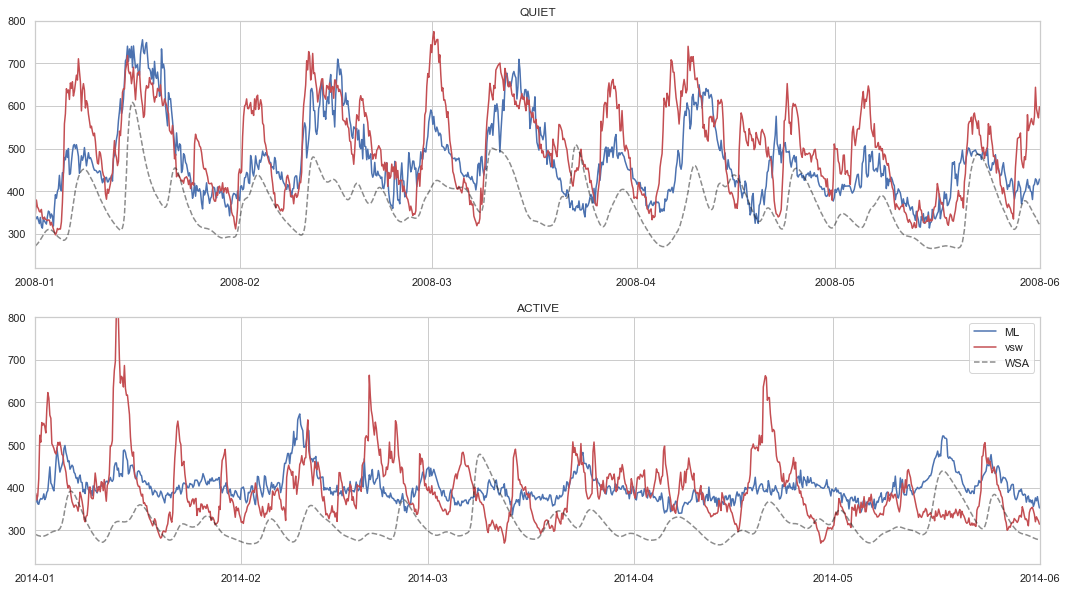

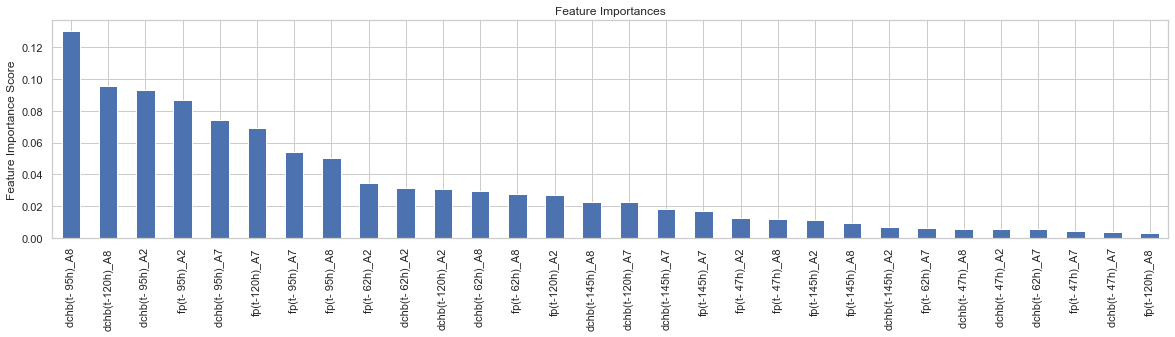

['dchb(t- 95h)_A8', 'dchb(t-120h)_A8', 'dchb(t- 95h)_A2', 'fp(t- 95h)_A2', 'dchb(t- 95h)_A7', 'fp(t-120h)_A7', 'fp(t- 95h)_A7', 'fp(t- 95h)_A8', 'fp(t- 62h)_A2', 'dchb(t- 62h)_A2']


In [14]:
fp_dchb_cols = [x for x in reduced_cols if ('fp' in x or 'dchb' in x)]
fp_dchb_cols = [x for x in fp_dchb_cols if x[-2:] in ['A2', 'A7', 'A8']]
print("Number of variables:", len(fp_dchb_cols))
print(fp_dchb_cols)
A_fp_dchb = AMBSOWI_model(fp_dchb_cols, xg_reg, verbose=False)
A_fp_dchb.extract_train_test_data(df, min_date.replace(tzinfo=None), max_date.replace(tzinfo=None))
A_fp_dchb.train_xgb_model(early_stopping_rounds=4)
print("")
print("RESULTS FOR FP/DCHB INPUT VALUES")
print("--------------------------------")
A_fp_dchb.print_rmse_values(df, min_date_test, max_date_test)
A_fp_dchb.plot_train_vs_test(df)
optim_cols = A_fp_dchb.plot_feature_importances()
print(optim_cols)
full_features = np.array(df[fp_dchb_cols])
A_fp_dchb.write_model_results('results/ml_vsw_predictions_fp+d.txt', full_features, np.array(df['mtimes']))

### Train model on optimal features + persistence

Number of variables: 33
['fp(t-145h)_A2', 'fp(t-120h)_A2', 'fp(t- 95h)_A2', 'fp(t- 62h)_A2', 'fp(t- 47h)_A2', 'dchb(t-145h)_A2', 'dchb(t-120h)_A2', 'dchb(t- 95h)_A2', 'dchb(t- 62h)_A2', 'dchb(t- 47h)_A2', 'fp(t-145h)_A7', 'fp(t-120h)_A7', 'fp(t- 95h)_A7', 'fp(t- 62h)_A7', 'fp(t- 47h)_A7', 'dchb(t-145h)_A7', 'dchb(t-120h)_A7', 'dchb(t- 95h)_A7', 'dchb(t- 62h)_A7', 'dchb(t- 47h)_A7', 'fp(t-145h)_A8', 'fp(t-120h)_A8', 'fp(t- 95h)_A8', 'fp(t- 62h)_A8', 'fp(t- 47h)_A8', 'dchb(t-145h)_A8', 'dchb(t-120h)_A8', 'dchb(t- 95h)_A8', 'dchb(t- 62h)_A8', 'dchb(t- 47h)_A8', 'pers', 'pers+1', 'pers-1']

RESULTS FOR FP+DCHB+PERS INPUT VALUES
-------------------------------------
XGB(train)  RMSE = 96.7 km/s	PCC = 0.66	STD = 81.24
XGB(val.)   RMSE = 99.1 km/s	PCC = 0.64	STD = 80.87
XGB(TEST)   RMSE = 77.8 km/s	PCC = 0.63	STD = 71.04
-------------------------------------------
WSA(train) RMSE = 145.1 km/s	PCC = 0.49	STD = 74.39
WSA(val.)  RMSE = 144.9 km/s	PCC = 0.48	STD = 73.99
WSA(TEST)  RMSE = 120.8 km

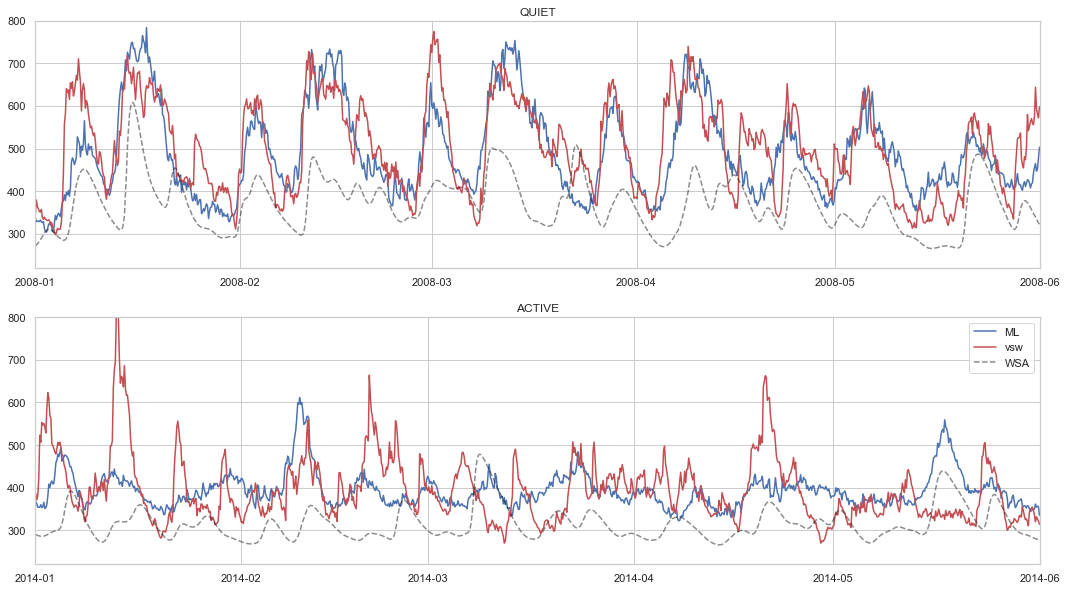

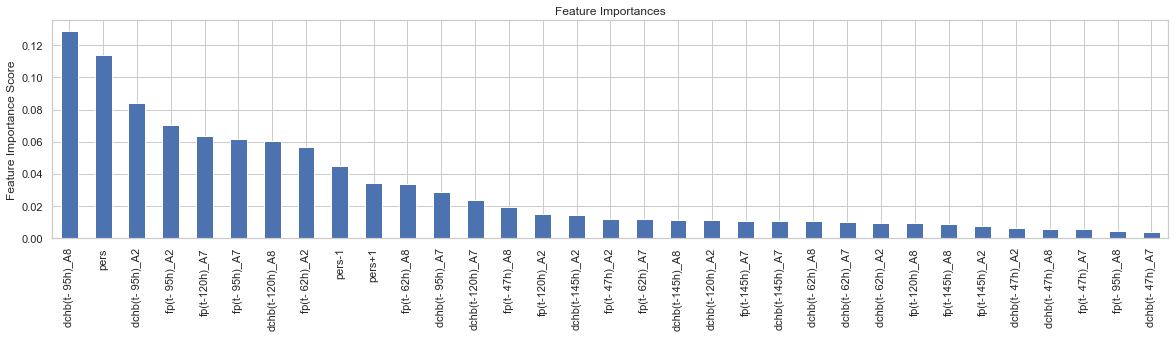

['dchb(t- 95h)_A8', 'pers', 'dchb(t- 95h)_A2', 'fp(t- 95h)_A2', 'fp(t-120h)_A7', 'fp(t- 95h)_A7', 'dchb(t-120h)_A8', 'fp(t- 62h)_A2', 'pers-1', 'pers+1']


In [15]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                          max_depth=3, alpha=10, n_estimators=600)
fp_dchb_pers_cols = fp_dchb_cols + ['pers', 'pers+1', 'pers-1']
print("Number of variables:", len(fp_dchb_pers_cols))
print(fp_dchb_pers_cols)
A_fp_dchb_pers = AMBSOWI_model(fp_dchb_pers_cols, xg_reg, verbose=False)
A_fp_dchb_pers.extract_train_test_data(df, min_date, max_date)
A_fp_dchb_pers.train_xgb_model(early_stopping_rounds=1)
print("")
print("RESULTS FOR FP+DCHB+PERS INPUT VALUES")
print("-------------------------------------")
A_fp_dchb_pers.print_rmse_values(df, min_date_test, max_date_test)
A_fp_dchb_pers.plot_train_vs_test(df)
optim_cols = A_fp_dchb_pers.plot_feature_importances()
print(optim_cols)
full_features = np.array(df[fp_dchb_pers_cols])
A_fp_dchb_pers.write_model_results('results/ml_vsw_predictions_fp+d+pers.txt', full_features, np.array(df['mtimes']))

In [16]:
# OPTIMISING HYPERPARAMETERS FOR FINAL XGBOOST MODEL
gridsearch = False
if gridsearch:
    xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree=0.3)
    A_xgbcv = AMBSOWI_model(fp_dchb_pers_cols, xg_reg, verbose=False)
    A_xgbcv.extract_train_test_data(df, min_date, max_date)

    # n_estimators=600 seems reasonable, go over this and it starts to really overfit
    param_grid = {'reg__n_estimators': [300, 500, 600],
                  'reg__learning_rate': [0.1, 0.3, 0.5],
                  'reg__max_depth': [2, 3],
                  'reg__alpha': [10, 20],
                  #'reg__eval_metric': ['mae', 'rmse'],
                 }
    pipe = Pipeline([('reg', A_xgbcv.model)])

    reg_pipe = GridSearchCV(pipe, param_grid=param_grid, cv=3, verbose=3)#, scoring=score)
    cv_model = reg_pipe.fit(A_xgbcv.X_train, A_xgbcv.y_train)
    best_params = cv_model.best_params_
    print(best_params)
else:
    # Skip cross-validation, these are the results:
    best_params = {'reg__alpha': 10, 'reg__learning_rate': 0.3, 'reg__max_depth': 3, 'reg__n_estimators': 600}
    print("Hyperparameters are: {}".format(best_params))


Hyperparameters are: {'reg__alpha': 10, 'reg__learning_rate': 0.3, 'reg__max_depth': 3, 'reg__n_estimators': 600}


In [17]:
# Save model to file:
model_file = "optim_ambsowi_model.pickle"
with open(model_file, 'wb') as f:
    pickle.dump([A_fp_dchb_pers.model, fp_dchb_pers_cols], f)

#### Look at the output for each input variable individually

In [17]:
for var in ['fp', 'dchb', 'bcor', 'bphot']:
    single_var_cols = [l for l in reduced_cols if var in l]
    print("Number of variables:", len(single_var_cols))
    print(single_var_cols)
    A_single_var = AMBSOWI_model(single_var_cols, xg_reg, verbose=False)
    A_single_var.extract_train_test_data(df, min_date, max_date)
    A_single_var.train_xgb_model(early_stopping_rounds=2)
    print("RESULTS FOR {} INPUT VALUES".format(var))
    print("-----------------------------")
    A_single_var.print_rmse_values(df, min_date_test, max_date_test)
    #A_single_var.plot_train_vs_test(df)
    #var_optim_cols = A_single_var.plot_feature_importances()
    full_features = np.array(df[single_var_cols])
    A_single_var.write_model_results('results/ml_vsw_predictions_{}.txt'.format(var), 
                                     full_features, np.array(df['mtimes']))
    print("")

Number of variables: 60
['fp(t-145h)_A0', 'fp(t-120h)_A0', 'fp(t- 95h)_A0', 'fp(t- 62h)_A0', 'fp(t- 47h)_A0', 'fp(t-145h)_A1', 'fp(t-120h)_A1', 'fp(t- 95h)_A1', 'fp(t- 62h)_A1', 'fp(t- 47h)_A1', 'fp(t-145h)_A2', 'fp(t-120h)_A2', 'fp(t- 95h)_A2', 'fp(t- 62h)_A2', 'fp(t- 47h)_A2', 'fp(t-145h)_A3', 'fp(t-120h)_A3', 'fp(t- 95h)_A3', 'fp(t- 62h)_A3', 'fp(t- 47h)_A3', 'fp(t-145h)_A4', 'fp(t-120h)_A4', 'fp(t- 95h)_A4', 'fp(t- 62h)_A4', 'fp(t- 47h)_A4', 'fp(t-145h)_A5', 'fp(t-120h)_A5', 'fp(t- 95h)_A5', 'fp(t- 62h)_A5', 'fp(t- 47h)_A5', 'fp(t-145h)_A6', 'fp(t-120h)_A6', 'fp(t- 95h)_A6', 'fp(t- 62h)_A6', 'fp(t- 47h)_A6', 'fp(t-145h)_A7', 'fp(t-120h)_A7', 'fp(t- 95h)_A7', 'fp(t- 62h)_A7', 'fp(t- 47h)_A7', 'fp(t-145h)_A8', 'fp(t-120h)_A8', 'fp(t- 95h)_A8', 'fp(t- 62h)_A8', 'fp(t- 47h)_A8', 'fp(t-145h)_A9', 'fp(t-120h)_A9', 'fp(t- 95h)_A9', 'fp(t- 62h)_A9', 'fp(t- 47h)_A9', 'fp(t-145h)_A10', 'fp(t-120h)_A10', 'fp(t- 95h)_A10', 'fp(t- 62h)_A10', 'fp(t- 47h)_A10', 'fp(t-145h)_A11', 'fp(t-120h)_A11',

In [19]:
pers_cols = ['pers', 'pers+1', 'pers-1']
print("Number of variables:", len(pers_cols))
A_pers = AMBSOWI_model(pers_cols, xg_reg, verbose=False)
A_pers.extract_train_test_data(df, min_date, max_date)
A_pers.train_xgb_model(early_stopping_rounds=4)
print("")
print("RESULTS FOR {} INPUT VALUES".format('PERS'))
print("-----------------------------")
A_pers.print_rmse_values(df, min_date_test, max_date_test)
full_features = np.array(df[pers_cols])
A_pers.write_model_results('results/ml_vsw_predictions_pers.txt', full_features, np.array(df['mtimes']))

Number of variables: 3

RESULTS FOR PERS INPUT VALUES
-----------------------------
XGB(train)  RMSE = 108.9 km/s	PCC = 0.54	STD = 67.07
XGB(val.)   RMSE = 109.3 km/s	PCC = 0.53	STD = 67.06
XGB(TEST)   RMSE = 84.1 km/s	PCC = 0.54	STD = 61.01
-------------------------------------------
WSA(train) RMSE = 145.1 km/s	PCC = 0.49	STD = 74.39
WSA(val.)  RMSE = 144.9 km/s	PCC = 0.48	STD = 73.99
WSA(TEST)  RMSE = 120.8 km/s	PCC = 0.44	STD = 66.72


## 5. Create plots of final results

In [15]:
# Read Carrington Rotation times:
def is_leap(year):
    if year % 4 == 0:
        return 1
    else:
        return 0
carr_rot = np.loadtxt("data/CarringtonRotNums.txt", skiprows=1)
n_crot = np.array(carr_rot[:,0])
t_crot = np.array([(datetime(int(t-t%1),1,1) + timedelta(days=t%1*365 + is_leap(int(t-t%1)))) for t in carr_rot[:,4]])
t_crot[1950]

datetime.datetime(1998, 8, 28, 13, 21, 47, 520002)

In [16]:
# Use best model:
model_file = "optim_ambsowi_model.pickle"
with open(model_file, 'rb') as f:
    optim_model, optim_labels = pickle.load(f)
# For cycle 23:
start_cr_23 = t_crot[2060]
end_cr_23 = start_cr_23 + timedelta(days=27.27*3)
all_features_23 = np.array(df[start_cr_23:end_cr_23][optim_labels])
cr_times_23 = np.array(df[start_cr_23:end_cr_23].index)
cr_vsw_23 = df[start_cr_23:end_cr_23]['vsw']
cr_wsa_23 = df[start_cr_23:end_cr_23]['wsa']
cr_pred_23 = optim_model.predict(all_features_23)
cr_pred_23 = cr_pred_23.reshape(-1,1)
# For cycle 24:
n_cr_24, num_crs = 2192, 5
start_cr_24 = t_crot[n_cr_24]#t_crot[2203]
end_cr_24 = start_cr_24 + timedelta(days=27.27*num_crs)
all_features_24 = np.array(df[start_cr_24:end_cr_24][optim_labels])
cr_times_24 = np.array(df[start_cr_24:end_cr_24].index)
cr_vsw_24 = df[start_cr_24:end_cr_24]['vsw']
cr_wsa_24 = df[start_cr_24:end_cr_24]['wsa']
cr_pred_24 = optim_model.predict(all_features_24)
cr_pred_24 = cr_pred_24.reshape(-1,1)
print("Carrington rotations: {} - {}".format(n_crot[n_cr_24], n_crot[n_cr_24+5]))

Carrington rotations: 2182.0 - 2187.0


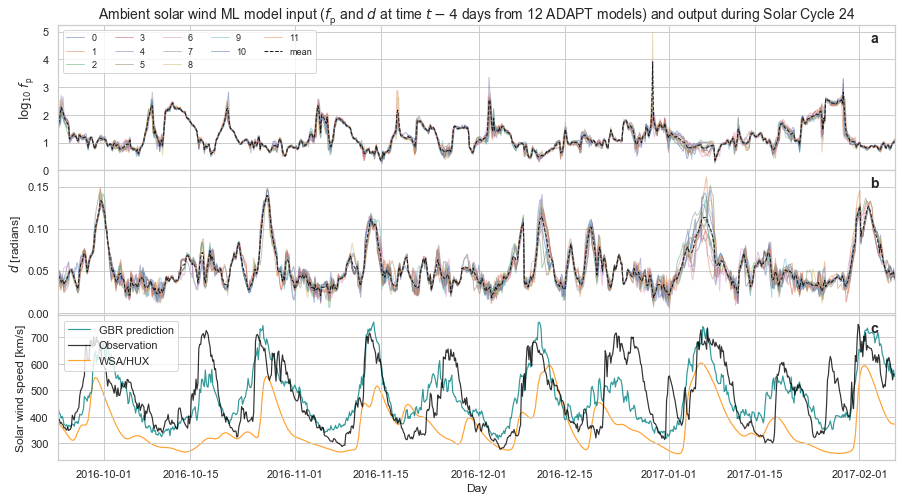

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(15,8), sharex=True)
alpha = 0.5
lw = 1
fp_avg, d_avg = np.zeros((len(cr_vsw_24))), np.zeros((len(cr_vsw_24)))
for i in range(12):
    fp = np.array(df[start_cr_24:end_cr_24]["fp(t- 95h)_A{}".format(i)])
    dchb = np.array(df[start_cr_24:end_cr_24]["dchb(t- 95h)_A{}".format(i)])
    fp_avg, d_avg = fp_avg + fp, d_avg + dchb
    ax1.plot_date(cr_times_24, np.log10(fp), '-', alpha=alpha, lw=lw, label=i)
    ax2.plot_date(cr_times_24, dchb, '-', alpha=alpha, lw=lw, label=i)
ax1.plot_date(cr_times_24, np.log10(fp_avg/12), 'k--', lw=lw, label='mean')
ax2.plot_date(cr_times_24, d_avg/12, 'k--', lw=lw, label='mean')

ax1.set_ylabel("$\log_{10}$ $f\mathregular{_p}$")
ax1.set_xlim((start_cr_24, end_cr_24))
ax1.set_title(r"Ambient solar wind ML model input ($f\mathregular{_p}$ and $d$ at time $t-4$ days from 12 ADAPT models) and output during Solar Cycle 24", fontsize=14)
ax1.legend(loc='upper left', ncol=5, fontsize=9)
ax2.set_ylabel("$d$ [radians]")
ax2.set_xlabel("Time")

c_vsw, c_ml, c_wsa = 'black', 'teal', 'darkorange'
lw = 1.2
alpha=0.8
ax3.plot_date(cr_times_24, cr_pred_24, '-', c=c_ml, lw=lw, alpha=alpha, label="GBR prediction")
ax3.plot_date(cr_times_24, cr_vsw_24, '-', c=c_vsw, lw=lw, alpha=alpha, label="Observation")
ax3.plot_date(cr_times_24, cr_wsa_24, '-', c=c_wsa, lw=lw, alpha=alpha, label="WSA/HUX", zorder=0)
ax3.set_ylabel("Solar wind speed [km/s]")
ax3.set_xlim((start_cr_24, end_cr_24))
#ax3.set_title("Ambient Solar Wind during Solar Cycle 24 (testing dataset)", fontsize=14)
ax3.legend(loc="upper left")
ax3.set_xlabel("Day")

for ax, ann in zip([ax1, ax2, ax3], ['a', 'b', 'c']):
    ax.text(0.97, 0.88, ann, transform=ax.transAxes, fontsize=14, weight='bold')
    #ax.grid(False)

plt.subplots_adjust(hspace=0.)
plt.savefig("plots/fp_d_plot.pdf")
plt.show()

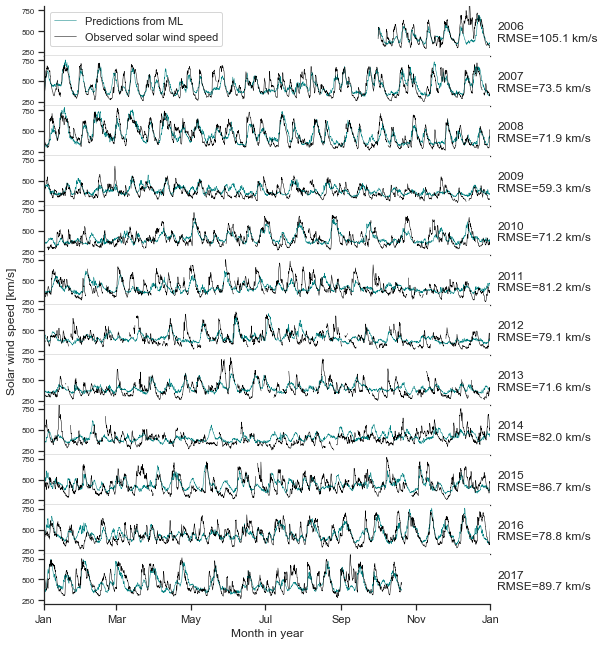

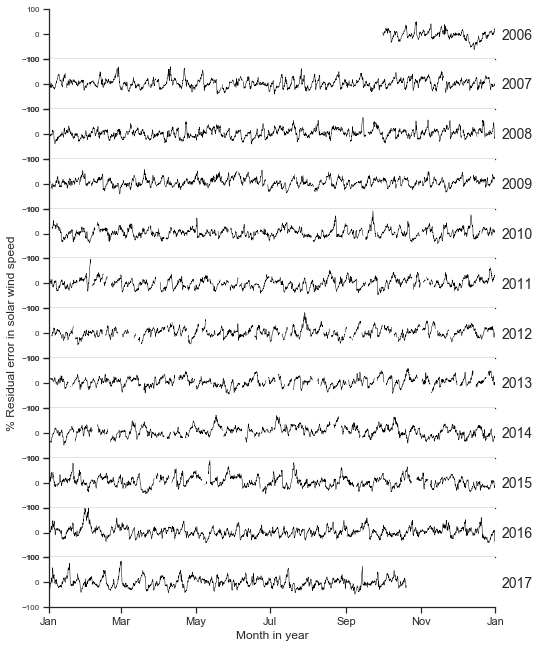

In [22]:
# Plot all years of testing data:
plotyears = range(2006,2018) # testing is (2006,10,10) till (2017,10,10)
fig, axes = plt.subplots(len(plotyears), 1, figsize=(8,11))
sns.set_style("ticks")
for iyear, plotyear in enumerate(plotyears):
    if plotyear == 2006:
        start_year, end_year = datetime(plotyear,10,1), datetime(plotyear+1,1,1)
    else:
        start_year, end_year = datetime(plotyear,1,1), datetime(plotyear+1,1,1)
    features_year = np.array(df[start_year:end_year][optim_labels])
    times_year = np.array(df[start_year:end_year].index)
    vsw_year = np.array(df_no_icmes[start_year:end_year]['vsw'])
    vsw_year_full = np.array(df[start_year:end_year]['vsw'])
    pred_year = optim_model.predict(features_year)
    axes[iyear].plot_date(times_year, pred_year, '-', c=c_ml, lw=0.5, label='Predictions from ML')
    axes[iyear].plot_date(times_year, vsw_year, '-', c=c_vsw, lw=0.5, label='Observed solar wind speed')
    axes[iyear].set_xlim((datetime(plotyear,1,1), datetime(plotyear+1,1,1)))
    axes[iyear].set_ylim((200,800))
    if plotyear != plotyears[-1]:
        axes[iyear].set_xticks([])
    if iyear == int(len(plotyears)/2.):
        axes[iyear].set_ylabel("Solar wind speed [km/s]")
    for tick in axes[iyear].yaxis.get_major_ticks():
        tick.label.set_fontsize(8) 
    axes[iyear].grid(False)
    rmse_year = np.sqrt(mean_squared_error(pred_year, vsw_year_full))
    #axes[iyear].text(1.015, 0.4, str(plotyear), transform=axes[iyear].transAxes, fontsize=14)
    axes[iyear].text(1.015, 0.3, str(plotyear)+'\n'+'RMSE={:.1f} km/s'.format(rmse_year), transform=axes[iyear].transAxes, fontsize=12)
axes[-1].xaxis.set_major_formatter(DateFormatter("%b"))
axes[-1].set_xlabel("Month in year")
axes[0].legend(loc='upper left')
sns.despine()
plt.subplots_adjust(hspace=0.)
#plt.gcf().subplots_adjust(right=1.1)
plt.savefig("plots/pred_all_years.pdf")
plt.savefig("plots/pred_all_years.png", dpi=600, bbox_inches='tight')
plt.show()

# Plot residual error for all years of testing data:
plotyears = range(2006,2018) # testing is (2006,10,10) till (2017,10,10)
fig, axes = plt.subplots(len(plotyears), 1, figsize=(8,11))
sns.set_style("ticks")
for iyear, plotyear in enumerate(plotyears):
    if plotyear == 2006:
        start_year, end_year = datetime(plotyear,10,1), datetime(plotyear+1,1,1)
    else:
        start_year, end_year = datetime(plotyear,1,1), datetime(plotyear+1,1,1)
    features_year = np.array(df[start_year:end_year][optim_labels])
    times_year = np.array(df[start_year:end_year].index)
    vsw_year = np.array(df_no_icmes[start_year:end_year]['vsw'])
    pred_year = optim_model.predict(features_year)
    axes[iyear].plot_date(times_year, (pred_year-vsw_year)/vsw_year*100., '-', c=c_vsw, lw=0.5)
    axes[iyear].set_xlim((datetime(plotyear,1,1), datetime(plotyear+1,1,1)))
    axes[iyear].set_ylim((-100,100))
    if plotyear != plotyears[-1]:
        axes[iyear].set_xticks([])
    if iyear == int(len(plotyears)/2.):
        axes[iyear].set_ylabel("% Residual error in solar wind speed")
    for tick in axes[iyear].yaxis.get_major_ticks():
        tick.label.set_fontsize(8) 
    axes[iyear].grid(False)
    axes[iyear].text(1.015, 0.4, str(plotyear), transform=axes[iyear].transAxes, fontsize=14)
axes[-1].xaxis.set_major_formatter(DateFormatter("%b"))
axes[-1].set_xlabel("Month in year")
sns.despine()
plt.subplots_adjust(hspace=0.)
plt.savefig("plots/error_all_years.pdf")
plt.savefig("plots/error_all_years.png", dpi=600, bbox_inches='tight')
plt.show()

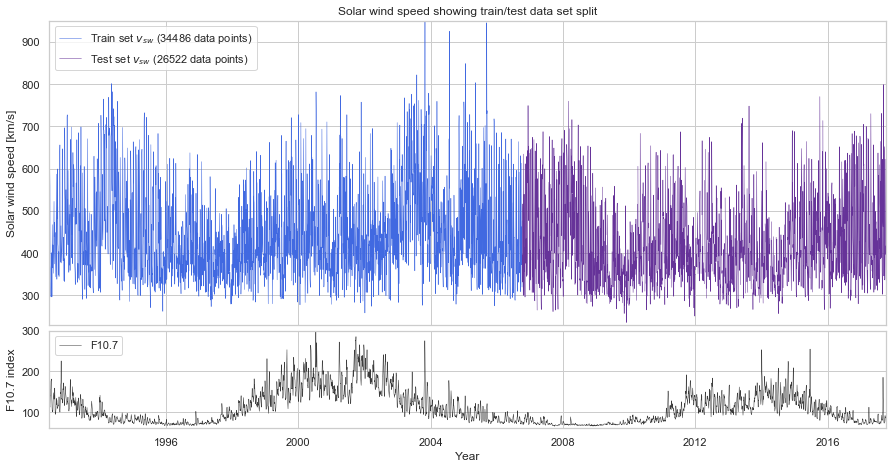

In [50]:
# Plot train/test split:
import matplotlib.gridspec as gridspec
sns.set_style("whitegrid")

fig = plt.figure(constrained_layout=False, figsize=(15, 7.5))
gs = fig.add_gridspec(4, 1)
ax1 = fig.add_subplot(gs[0:3, 0])
ax2 = fig.add_subplot(gs[3, 0], sharex=ax1)

times_year = np.array(df[min_date:max_date_test].index)
times_year_train = np.array(df[min_date:max_date].index)
times_year_test = np.array(df[min_date_test:max_date_test].index)
vsw_year_train = np.array(df_no_icmes[min_date:max_date]['vsw'])
str_len_train = ' ({} data points)'.format(len(vsw_year_train))
vsw_year_test = np.array(df_no_icmes[min_date_test:max_date_test]['vsw'])
str_len_test = ' ({} data points)'.format(len(vsw_year_test))

f10_7 = np.interp(date2num(times_year), omni['time'], omni['f10.7'])

skip = 13
ax1.plot_date(times_year_train[::skip], vsw_year_train[::skip], '-', c='royalblue', lw=0.5, label=r'Train set $v_{sw}$'+str_len_train)
ax1.plot_date(times_year_test[::skip], vsw_year_test[::skip], '-', c='rebeccapurple', lw=0.5, label=r'Test set $v_{sw}$'+str_len_test)
ax1.set_xlim((min_date, max_date_test))
ax1.set_ylim((230,950))
ax1.set_xticks([])
ax1.set_ylabel("Solar wind speed [km/s]")
ax1.legend(loc='upper left')
ax1.set_title("Solar wind speed showing train/test data set split")
ax2.plot_date(times_year[::13], f10_7[::13], '-', c='k', lw=0.5, label='F10.7', alpha=0.85)
ax2.set_ylim([60,300])
ax2.set_ylabel("F10.7 index")
ax2.set_xlabel("Year")
ax2.legend(loc='upper left')
plt.subplots_adjust(hspace=0.06)
plt.savefig("plots/vsw_all_years.png", dpi=600, bbox_inches='tight')
plt.show()

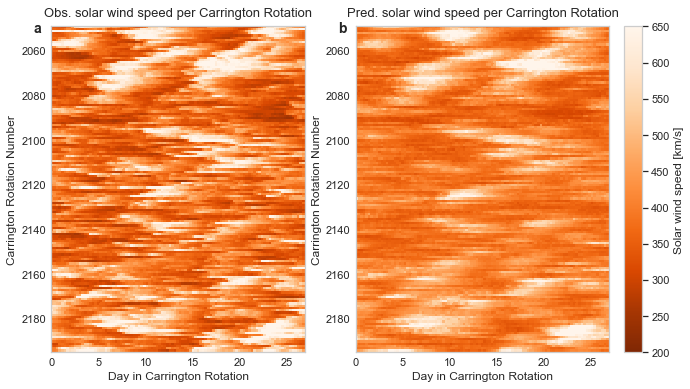

In [24]:
# Plot all Carrington Rotations of testing data:
n_timesteps = 100
cr_testing = t_crot[np.logical_and(t_crot >= min_date_test, t_crot < max_date_test)]
n_crot_testing = n_crot[np.logical_and(t_crot >= min_date_test, t_crot < max_date_test)]
all_cr_pred = np.zeros((len(cr_testing), n_timesteps))
all_cr_vsw = np.zeros((len(cr_testing), n_timesteps))
for i_cr, cr in enumerate(cr_testing[:-1]):
    cr_start, cr_end = cr, cr_testing[i_cr+1]
    times_ncr = np.arange(date2num(cr_start), date2num(cr_end)-1./24., 
                          (date2num(cr_end)-date2num(cr_start))/n_timesteps)
    features_cr = np.array(df[cr_start:cr_end][optim_labels])
    times_cr = date2num(np.array(df[cr_start:cr_end].index))
    vsw_cr = np.array(df[cr_start:cr_end]['vsw'])
    pred_cr = optim_model.predict(features_cr)
    pred_ncr = np.interp(times_ncr, times_cr, pred_cr)
    vsw_ncr = np.interp(times_ncr, times_cr, vsw_cr)
    all_cr_pred[i_cr,:] = pred_ncr
    all_cr_vsw[i_cr,:] = vsw_ncr
    
sns.set(style="whitegrid")
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,6))
# Create new colormap:
from matplotlib.colors import ListedColormap
RGB_cmap = (189,114,28)
N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(RGB_cmap[0]/256, 1, N)
vals[:, 1] = np.linspace(RGB_cmap[1]/256, 1, N)
vals[:, 2] = np.linspace(RGB_cmap[2]/256, 1, N)
newcmp = ListedColormap(vals)
# Plot data:
cmap_name = 'Oranges_r'#newcmp
axim1 = ax1.pcolor(times_ncr-times_ncr[0], n_crot_testing, all_cr_vsw, vmin=200., vmax=650., cmap=cmap_name)
axim2 = ax2.pcolor(times_ncr-times_ncr[0], n_crot_testing, all_cr_pred, vmin=200., vmax=650., cmap=cmap_name)
# Add colorbar:
for ax, ann in zip([ax1, ax2], ['a', 'b']):
    ax.text(-0.07, 0.98, ann, transform=ax.transAxes, fontsize=14, weight='bold')
cbaxes = fig.add_axes([0.92, 0.1245, 0.025, 0.755])
cb = plt.colorbar(axim2, cax=cbaxes)
axim1.set_edgecolor("face")
axim2.set_edgecolor("face")
ax1.set_xlabel("Day in Carrington Rotation")
ax1.set_ylim((n_crot_testing[-1], n_crot_testing[0]))
ax1.set_ylabel("Carrington Rotation Number")
ax1.tick_params(pad=-0.5, direction='out', length=6, width=2, grid_alpha=0.5)
ax1.set_title("Obs. solar wind speed per Carrington Rotation", fontsize=13, pad=10)
ax2.set_xlabel("Day in Carrington Rotation")
ax2.set_ylim((n_crot_testing[-1], n_crot_testing[0]))
ax2.set_ylabel("Carrington Rotation Number")
ax2.tick_params(pad=-0.5, direction='out', length=6, width=2, grid_alpha=0.5)
ax2.set_title("Pred. solar wind speed per Carrington Rotation", fontsize=13, pad=10)
cbaxes.set_ylabel("Solar wind speed [km/s]")
plt.savefig("plots/cr_speed_implot.pdf")
plt.show()

#### Produce output files for ISWAT ambient solar wind forecasting group

In [25]:
# Use best model:
with open("optim_ambsowi_model.pickle", 'rb') as f:
    optim_model, optim_labels = pickle.load(f)
# One year (2008)
start_2008, end_2008 = datetime(2008,1,1), datetime(2009,1,1)
all_features_2008 = np.array(df[start_2008:end_2008][optim_labels])
pred_2008 = optim_model.predict(all_features_2008)
dates_2008 = np.array(df.loc[start_2008:end_2008].index)
df_2008 = pd.DataFrame(data={'date': dates_2008, 'predictions': pred_2008})
df_2008.to_csv("results/bailey_ml_vsw_iswat_2008.csv")
# One year (2012)
start_2012, end_2012 = datetime(2012,1,1), datetime(2013,1,1)
all_features_2012 = np.array(df[start_2012:end_2012][optim_labels])
pred_2012 = optim_model.predict(all_features_2012)
dates_2012 = np.array(df.loc[start_2012:end_2012].index)
df_2012 = pd.DataFrame(data={'date': dates_2012, 'predictions': pred_2012})
df_2012.to_csv("results/bailey_ml_vsw_iswat_2012.csv")

# Time the prediction for one year of data:
%timeit optim_model.predict(all_features_2008)
# Time for four day forecast:
start_4days, end_4days = datetime(2008,1,1), datetime(2008,1,5)
all_features_4days = np.array(df[start_4days:end_4days][optim_labels])
pred_4days = optim_model.predict(all_features_4days)
%timeit optim_model.predict(all_features_4days)

5.32 ms ± 229 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
96.7 µs ± 5.5 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


#### Comparison to Chandorkar et al. (2020)

CR #2077: 2008-11-20 07:01:20.640000 - 2008-12-17 14:40:16.320000
MAE: 45.19, RMSE: 56.75
MAE (pers): 59.05, RMSE (pers): 71.30


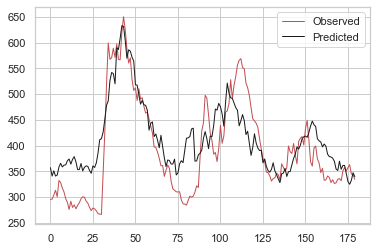

In [26]:
start_cr2077 = datetime(2008, 11, 20) + timedelta(hours=0.2926*24.)
end_cr2077 = datetime(2008, 12, 17) + timedelta(hours=0.6113*24.)
print("CR #2077:", start_cr2077, '-', end_cr2077)

# Make predictions from features:
all_features_cr2077 = np.array(df[start_cr2077:end_cr2077][optim_labels])
pred_cr2077 = optim_model.predict(all_features_cr2077)

# Check RMSE:
vsw_cr2077 = np.array(df[start_cr2077:end_cr2077]['vsw'])
pers_cr2077 = np.array(df[start_cr2077:end_cr2077]['pers'])
rmse_cr2077 = np.sqrt(mean_squared_error(pred_cr2077, vsw_cr2077))
mae_cr2077 = np.sum(np.abs(pred_cr2077 - vsw_cr2077)) / len(vsw_cr2077)
rmse_pers_cr2077 = np.sqrt(mean_squared_error(pers_cr2077, vsw_cr2077))
mae_pers_cr2077 = np.sum(np.abs(pers_cr2077 - vsw_cr2077)) / len(vsw_cr2077)
print("MAE: {:.2f}, RMSE: {:.2f}".format(mae_cr2077, rmse_cr2077))
print("MAE (pers): {:.2f}, RMSE (pers): {:.2f}".format(mae_pers_cr2077, rmse_pers_cr2077))

# Plot to check (can compare to Fig. 6 in Appendix in Chandorkar et al. (2020))
fig = plt.figure(figsize=(6,4))
plt.plot(vsw_cr2077, 'r-', lw=1, label="Observed")
plt.plot(pred_cr2077, 'k-', lw=1, label="Predicted")
plt.legend()
plt.show()

## 6. Example of Model Application

The code below demonstates how to apply the model to a new dataset. A test set of data is provided.

First date (CMM): 2017-08-26 21:17:31.228800+00:00
Last date (CMM):  2017-10-20 06:36:57.628800+00:00
Data resolution is 3.64 hours.
Labels for extraction: ['fp(t-145h)_A2', 'fp(t-120h)_A2', 'fp(t- 95h)_A2', 'fp(t- 62h)_A2', 'fp(t- 47h)_A2', 'dchb(t-145h)_A2', 'dchb(t-120h)_A2', 'dchb(t- 95h)_A2', 'dchb(t- 62h)_A2', 'dchb(t- 47h)_A2', 'fp(t-145h)_A7', 'fp(t-120h)_A7', 'fp(t- 95h)_A7', 'fp(t- 62h)_A7', 'fp(t- 47h)_A7', 'dchb(t-145h)_A7', 'dchb(t-120h)_A7', 'dchb(t- 95h)_A7', 'dchb(t- 62h)_A7', 'dchb(t- 47h)_A7', 'fp(t-145h)_A8', 'fp(t-120h)_A8', 'fp(t- 95h)_A8', 'fp(t- 62h)_A8', 'fp(t- 47h)_A8', 'dchb(t-145h)_A8', 'dchb(t-120h)_A8', 'dchb(t- 95h)_A8', 'dchb(t- 62h)_A8', 'dchb(t- 47h)_A8', 'pers', 'pers+1', 'pers-1']


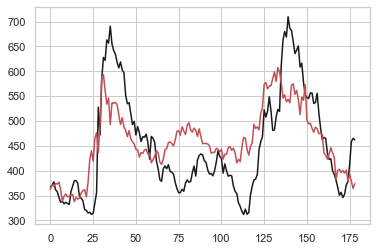

In [27]:
# (1) PREPARE INPUT DATA
# Load coronal model input data:
numdates_new, dates_all_new, mtimes_new, fp_new, dchb_new, bcor_new, bphot_new = read_cmm_output("data/arge_test.txt")
# Get solar wind data for persistence:
omni = ps.get_omni_data(filepath="data/omni2_all_years.dat")
omni.interp_nans()
vsw_new = np.interp(numdates_new, omni['time'], omni['speed'])
wsa_hux_new = vsw_new # use dummy array, don't need it here
# Roll by 180 points (1 Carrington rotation) for persistence:
if include_pers:
    pers_new = np.roll(vsw_new, 180)
    pers_1up_new = np.roll(vsw_new, 173)    # CR -1 day
    pers_1down_new = np.roll(vsw_new, 187)  # CR +1 day
df_new, all_labels_new = pack_into_dataframe(numdates_new, mtimes_new, fp_new, dchb_new, bcor_new, bphot_new, 
                                             pers_new, pers_1up_new, pers_1down_new, 
                                             vsw_new, wsa_hux_new, look_back=42)
# Only valid for +27 days (180) of first point due to inclusion of persistence:
df_new = df_new[matlab2datetime(mtimes_new[180]):matlab2datetime(mtimes_new[-1])]

# (2) LOAD MODEL
with open("optim_ambsowi_model.pickle", 'rb') as f:
    optim_model, optim_labels = pickle.load(f)
print("Labels for extraction:", optim_labels)
    
# (3) EXTRACT FEATURES
features_new = np.array(df_new[optim_labels])

# (4) APPLY MODEL TO DATA
predictions = optim_model.predict(features_new)
# Check it worked:
fig = plt.figure()
plt.plot(np.array(df_new['vsw']), 'k-')
plt.plot(predictions, 'r-')